In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import rfpimp

def randomForest(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state = 0)
    print(f'train : {len(y_train)}, test : {len(y_test)}')
    #sc = StandardScaler()
    #X_train = sc.fit_transform(X_train)
    #X_test = sc.transform(X_test)

    regressor = RandomForestRegressor(n_estimators=400, n_jobs = -1, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print(f'Explained Variance : {metrics.explained_variance_score(y_test, y_pred)} ')
    print(f'R² : {metrics.r2_score(y_test, y_pred)} ')
    
    return regressor, y_test, y_pred, X_test


In [8]:
df_corr = pd.read_csv('magnaprobe_clean_Greiner.csv')
df_corr.columns

Index(['Unnamed: 0', 'Lat', 'Lon', 'depth', 'year', 'Eco_majori', 'aspect_mea',
       'slope_mean', 'Sx_mean', 'TPI_mean', 'elev_mean', 'ndvi_mean',
       'TPI_500_me', 'TPI_1000_m', 'TPI_5km_me', 'TPI_10km_m', 'geometry',
       'u_sd_temp'],
      dtype='object')

In [11]:
X = pd.DataFrame({'Sx' : df_corr.Sx_mean, 'TPI_150m' : df_corr.TPI_mean, 'Slope' : df_corr.slope_mean, 
                  #'Aspect' : df_corr.aspect_mea,
                  #'Elevation' : df_corr.elev_mean, 
                  'Ecotype' : df_corr.Eco_majori, 
                  #'Veg Height' : df_corr.Veg_height,
                  #'NDVI' : df.ndvi_mean,
                  'Year mean' : df_corr.u_sd_temp,
                  #'TPI_500' : df_corr.TPI_500_me,
                  #'TPI_1km' : df_corr.TPI_1000_m,
                  'TPI_5km' : df_corr.TPI_5km_me,
                  #'TPI_10km' : df_corr.TPI_10km_m,
                 })

y = df_corr.loc[:,"depth"]/100
#X = clean_dataset(X)
regressor, y_test, y_pred, X_test = randomForest(X,y)
hist_y_corr = regressor.feature_importances_
perm_imp = rfpimp.importances(regressor, X_test, y_test)

train : 8741, test : 8742
Mean Absolute Error: 0.057392548540425185
Root Mean Squared Error: 0.08095105320998963
Explained Variance : 0.7862682428342173 
R² : 0.786259836029238 


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

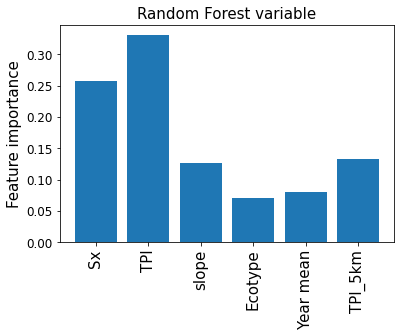

In [12]:
label = ['Sx', 'TPI', 'slope', 'Ecotype', 'Year mean', 'TPI_5km']
plt.xticks(rotation=90)
plt.bar(label, hist_y_corr)
plt.ylabel('Feature importance', size = 15)
plt.title('Random Forest variable', size = 15)
plt.yticks(size = 12)
plt.xticks(size = 15)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

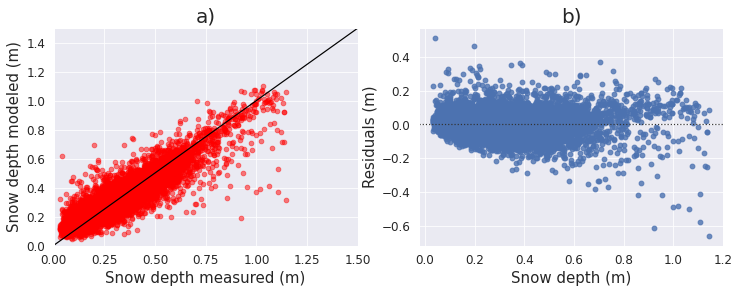

In [10]:
#Graph validation from RF prediction

#sns.set('paper')
plt.figure(figsize = (12,4))
plt.subplot(121)
plt.title('a)', size = 20)
x = np.linspace(0,1.5,100)
plt.plot(x,x, color = 'black')
plt.xlim(0,1.5)
plt.ylim(0,1.5)
plt.yticks(size = 12)
plt.xticks(size = 12)
plt.ylabel('Snow depth modeled (m)', size = 15)
plt.xlabel('Snow depth measured (m)', size = 15)
plt.scatter(y_test, y_pred, color = 'red', alpha = 0.5)

plt.subplot(122)
plt.title('b)', size = 20)
sns.residplot(x = y_test, y = y_pred)
plt.ylabel('Residuals (m)', size = 15)
plt.xlabel('Snow depth (m)', size =15)
plt.yticks(size = 12)
plt.xticks(size = 12)

## Prepare input for entire watershed

In [11]:
import xarray as xr
import rasterio as rio

In [19]:
data = xr.open_dataset('RF_variable_GreinerWatershed.nc')

<xarray.DataArray 'eco' (y: 4483, x: 7765)>
[34810495 values with dtype=float64]
Coordinates:
  * x        (x) float64 4.8e+05 4.8e+05 4.8e+05 ... 5.576e+05 5.577e+05
  * y        (y) float64 7.695e+06 7.695e+06 7.695e+06 ... 7.65e+06 7.65e+06
Attributes:
    transform:   [ 1.00000001e+01  0.00000000e+00  4.80014738e+05  0.00000000...
    res:         [10.00000006 10.00000006]
    is_tiled:    0
    nodatavals:  nan
    scales:      1.0
    offsets:     0.0

In [16]:
tmp_tpi = data.TPI_150m.values.flatten()
tmp_sx = data.Sx_R100_W315.values.flatten()
tmp_slope = data.slope.values.flatten()
tmp_elev = data.elev.values.flatten()
tmp_eco = data.eco.values.flatten()

In [17]:
shape = data.TPI_150m.values.shape
#get index of pixel for correspondace of value predicted by RF
XX,YY = np.meshgrid(np.arange(shape[1]),np.arange(shape[0]))

#remove water value from prediction in RF with ecotype 1,2 and 3
eco = data.eco.values
indexx, indexy = np.where(eco == 1)

In [20]:
#set mean values for entire watershed, this set by user
#lets use a 40cm mean
y_mean = np.ones(len(tmp_sx)) * 0.40

In [21]:
#building X and Y variable for prediction
#order of Variable needs to match regressor from training data
X_data = pd.DataFrame({'Sx' : tmp_sx, 'TPI' : tmp_tpi, 'Slope' : tmp_slope,
                       #'Aspect' : tmp_aspect, 
                       'Elevation' : tmp_elev,
                       'Ecotype' : tmp_eco,
                       'Year mean' : y_mean,
                       'XX' : XX.flatten(), 'YY' : YY.flatten()}).dropna()

XX_clean = np.array(X_data.XX)
YY_clean = np.array(X_data.YY)
X_data = X_data.drop(labels = ['XX', 'YY'], axis = 1)

In [22]:
Y_pred = regressor.predict(X_data)

In [24]:
XX_clean = np.array(XX_clean)
YY_clean = np.array(YY_clean)

In [25]:
arr = np.zeros(shape)
arr.fill(np.nan)
for i in np.arange(len(XX_clean)):
    arr[YY_clean[i], XX_clean[i]] = Y_pred[i]

In [27]:
import rioxarray

indexx, indexy = np.where(eco == 1)
arr[(indexx, indexy)]=np.nan
indexx, indexy = np.where(eco == 2)
arr[(indexx, indexy)]=np.nan
indexx, indexy = np.where(eco == 3)
arr[(indexx, indexy)]=np.nan

snow = xr.DataArray(arr, coords = [data.eco.y.values, data.eco.x.values], dims = [ 'y', 'x'])
snow.rio.write_crs(26913)
snow.rio.to_raster("Ecotype_Greiner_snowRF.tif")